In [1]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
exp = 'FR1'

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):


## Plot CA3 v. DG on same plot

Test 1 p-value: 6.035028723471036e-10
Test 2 p-value: 9.471208597621017e-05


NameError: name 'start_array' is not defined

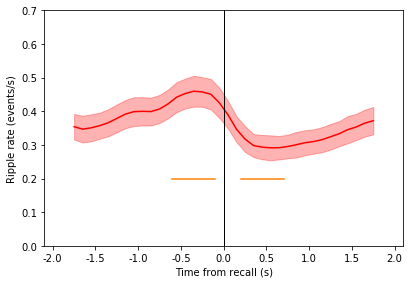

In [8]:
# load data from each

selected_period = 'surrounding_recall' 
remove_soz_ictal = False
recall_type_switch = 3 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC 
# location_selected = 'ca1' # 'ca3' # 'dg' 'ca1' # sub # left hippocampus # right hippocampus # hippocampus
# # (leave as '' if not HPC)

pad = 2
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period)

for p,location_selected in enumerate(['ca1','dg']):
    
    if p==1:
        color = (0,0,1)
        label = 'CA1'
    else:
        color = (1,0,0)
        label = 'Dentate gyrus'

    path_name = '/home1/john/SWR/figures/'+subfolder
    fn = os.path.join(path_name,
        'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+'.p')            
    with open(fn,'rb') as f:
        dat = pickle.load(f)
        bin_centers = dat['bin_centers']; PSTH = dat['PSTH']; CI_plot = dat['CI_plot'];
        bin_model1 = dat['bin_model1']; bin_model2 = dat['bin_model2']

    # make plot
    subplots(1,1,figsize=(6,4))
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)

    # plot smoothed mean +/- CI
    if pad > 0:
        plot(xr[pad:-pad],PSTH[pad:-pad],color=color)
        fill_between(xr[pad:-pad], PSTH[pad:-pad]-CI_plot[0,:], PSTH[pad:-pad]+CI_plot[0,:],color=color, alpha = 0.3)
    else:
        plot(xr,PSTH)
        fill_between(xr, PSTH-CI_plot[0,:], PSTH+CI_plot[0,:],color=color, alpha = 0.3)
    # bootstrap SE using random sample with replacement

    xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
    xlabel('Time from recall (s)')
    ylabel('Ripple rate (events/s)')
    tight_layout()
    ax = plt.gca()
    ylim = 0.7 # keep it here since occasionally CIs get kinda high
    ax.set_ylim(0,ylim)
    ax.set_xlim(psth_start-100,psth_end+100)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
    x_width = [ax.get_xlim()[0],ax.get_xlim()[1]]

    # plot bands of significance
    if bin_model1.pvalues[1] < 0.05:
        plot([first_end-stats_bin,first_end],[0.2,0.2],color=(1,0.5,0))
    if bin_model2.pvalues[1] < 0.05:
        plot([second_start,second_start+stats_bin],[0.2,0.2],color=(1,0.5,0))
    print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
    print('Test 2 p-value: '+str(bin_model2.pvalues[1]))
    print(str(start_array.shape[0])+' recalls')

a=1;